Import packages

In [1]:
from dataretrieval import nwis
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

Identify USGS site IDs and dates

In [2]:
siteNumber = ["12305000","06038800", "13340600", "13092747","13311000", "14197900"
             ] 
parameterCode = "00060" # Discharge
startDate = "1990-10-01"
endDate = "2024-09-30"
idv=[ "00060_Mean" ,"tmean" ]

Retrive site infomation

In [3]:
site_info = nwis.get_info(sites= siteNumber )

site_info_df = pd.DataFrame( site_info[0] )

print( site_info_df )

#print( site_info_df.columns )

site_info_df["site_no"]=site_info_df["site_no"].astype(str)

columns_to_save = ['site_no', 'dec_lat_va', 'dec_long_va']

filtered_df = site_info_df[columns_to_save]

print(filtered_df)

filtered_df.to_csv('site_info_df.csv', index=False)

  agency_cd   site_no                                       station_nm  \
0      USGS  06038800       Madison River at Kirby Ranch nr Cameron MT   
1      USGS  12305000                     KOOTENAI RIVER AT LEONIA, ID   
2      USGS  13092747    ROCK CREEK AB HWY 30/93 XING AT TWIN FALLS ID   
3      USGS  13311000            EF OF SF SALMON RIVER AT STIBNITE, ID   
4      USGS  13340600  NF CLEARWATER RIVER NR CANYON RANGER STATION ID   
5      USGS  14197900                  WILLAMETTE RIVER AT NEWBERG, OR   

  site_tp_cd     lat_va     long_va  dec_lat_va  dec_long_va coord_meth_cd  \
0         ST  445319.16  1113451.19   44.888656  -111.580886             N   
1         ST  483700.78  1160257.10   48.616883  -116.049194             N   
2         ST  423345.00  1142941.00   42.562500  -114.494722             M   
3         ST  445420.60  1151946.20   44.905722  -115.329500             N   
4         ST  465026.00  1153716.00   46.840556  -115.621111             G   
5         ST 

Extract stream temp data

In [4]:
parameterCode = ["00010" ,"00060"]

dailyStreamtemp = nwis.get_dv(sites=siteNumber, parameterCd=parameterCode, start=startDate, end=endDate) 

dailyStreamtemp_df = pd.DataFrame( dailyStreamtemp[0] )
dailyStreamtemp_df = dailyStreamtemp_df.reset_index()
dailyStreamtemp_df['Date'] = dailyStreamtemp_df['datetime'].dt.date
dailyStreamtemp_df['Month'] = dailyStreamtemp_df['datetime'].dt.month
dailyStreamtemp_df['Year'] = dailyStreamtemp_df['datetime'].dt.year

# Remove rows containing NaN values
dailyStream_df = dailyStreamtemp_df.dropna()

print( dailyStream_df)

        site_no                  datetime  00010_Maximum 00010_Maximum_cd  \
561    06038800 1995-04-12 00:00:00+00:00            5.5                A   
562    06038800 1995-04-13 00:00:00+00:00            6.5                A   
563    06038800 1995-04-14 00:00:00+00:00            6.0                A   
564    06038800 1995-04-15 00:00:00+00:00            6.5                A   
565    06038800 1995-04-16 00:00:00+00:00            6.5                A   
...         ...                       ...            ...              ...   
63918  14197900 2024-09-26 00:00:00+00:00           17.3                P   
63919  14197900 2024-09-27 00:00:00+00:00           16.8                P   
63920  14197900 2024-09-28 00:00:00+00:00           16.8                P   
63921  14197900 2024-09-29 00:00:00+00:00           16.6                P   
63922  14197900 2024-09-30 00:00:00+00:00           16.5                P   

       00010_Minimum 00010_Minimum_cd  00010_Mean 00010_Mean_cd  00060_Mean

GEE PRISM: https://code.earthengine.google.com/12de9c666ea94a1111f489bea638dd58

In [5]:
shared_url = "https://drive.google.com/file/d/1fAeIzkP8cRqY3iFmFHa9TbBKoE6lxQJh/view?usp=share_link"

# Extract the file ID
file_id = shared_url.split('/d/')[1].split('/')[0]

# Create the direct download URL
download_url = f"https://drive.google.com/uc?id={file_id}"

# Read the CSV file into a pandas DataFrame
prism_df = pd.read_csv(download_url)

prism_df['date'] = pd.to_datetime( prism_df['date'])

def days_since_october_first(date):
    october_first = pd.Timestamp(year=date.year, month=10, day=1)
    days_difference = (date - october_first).days
    # Adjust for negative values (wrap-around)
    return days_difference if days_difference >= 0 else days_difference + 365

# Apply the function to calculate days since October 1st
prism_df['Days_Since_October_1st'] =  prism_df['date'].apply(days_since_october_first)

prism_df[ "rad_d"   ] = 2 * np.pi * prism_df[ "Days_Since_October_1st"   ] /365

prism_df["site_no"] =prism_df["site_no"].astype(str)

# Add a leading 0 to strings with exactly 7 characters
prism_df['site_no'] = prism_df['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)

prism_df["site_no"] =prism_df["site_no"].astype(str)

print( prism_df)

print( prism_df.dtypes )

print(  prism_df["site_no"].unique()  )

print(siteNumber)

            date      tmean   site_no  Days_Since_October_1st     rad_d
0     1995-01-01 -18.306002  06038800                      92  1.583707
1     1995-01-02 -17.829000  06038800                      93  1.600921
2     1995-01-03 -18.317001  06038800                      94  1.618135
3     1995-01-04 -15.904000  06038800                      95  1.635350
4     1995-01-05 -11.903001  06038800                      96  1.652564
...          ...        ...       ...                     ...       ...
54395 2024-10-10   9.048050  13311000                       9  0.154928
54396 2024-10-11   9.102850  13311000                      10  0.172142
54397 2024-10-12   9.169550  13311000                      11  0.189356
54398 2024-10-13  10.279050  13311000                      12  0.206570
54399 2024-10-14  10.417600  13311000                      13  0.223785

[54400 rows x 5 columns]
date                      datetime64[ns]
tmean                            float64
site_no                     

In [6]:
def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T, # importances : Raw permutation importance scores.
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

12305000
dailyStreamtemp_df2:         site_no                  datetime  00010_Maximum 00010_Maximum_cd  \
18995  12305000 2011-09-30 00:00:00+00:00           14.4                A   
18996  12305000 2011-10-01 00:00:00+00:00           15.5                A   
18997  12305000 2011-10-02 00:00:00+00:00           15.5                A   
18998  12305000 2011-10-03 00:00:00+00:00           15.5                A   
18999  12305000 2011-10-04 00:00:00+00:00           14.5                A   
...         ...                       ...            ...              ...   
23740  12305000 2024-09-26 00:00:00+00:00           15.7                P   
23741  12305000 2024-09-27 00:00:00+00:00           14.3                P   
23742  12305000 2024-09-28 00:00:00+00:00           14.1                P   
23743  12305000 2024-09-29 00:00:00+00:00           14.2                P   
23744  12305000 2024-09-30 00:00:00+00:00           13.6                P   

       00010_Minimum 00010_Minimum_cd  00010_

/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_8265/3331447402.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prism_df2['sin_rday'] = np.sin( prism_df2['rad_d'] )
/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_8265/3331447402.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prism_df2['cos_rday'] = np.cos( prism_df2['rad_d'] )
/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_8265/3331447402.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

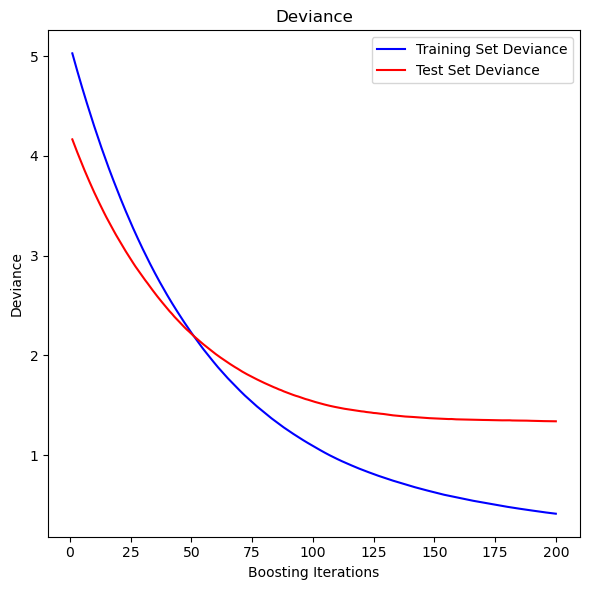

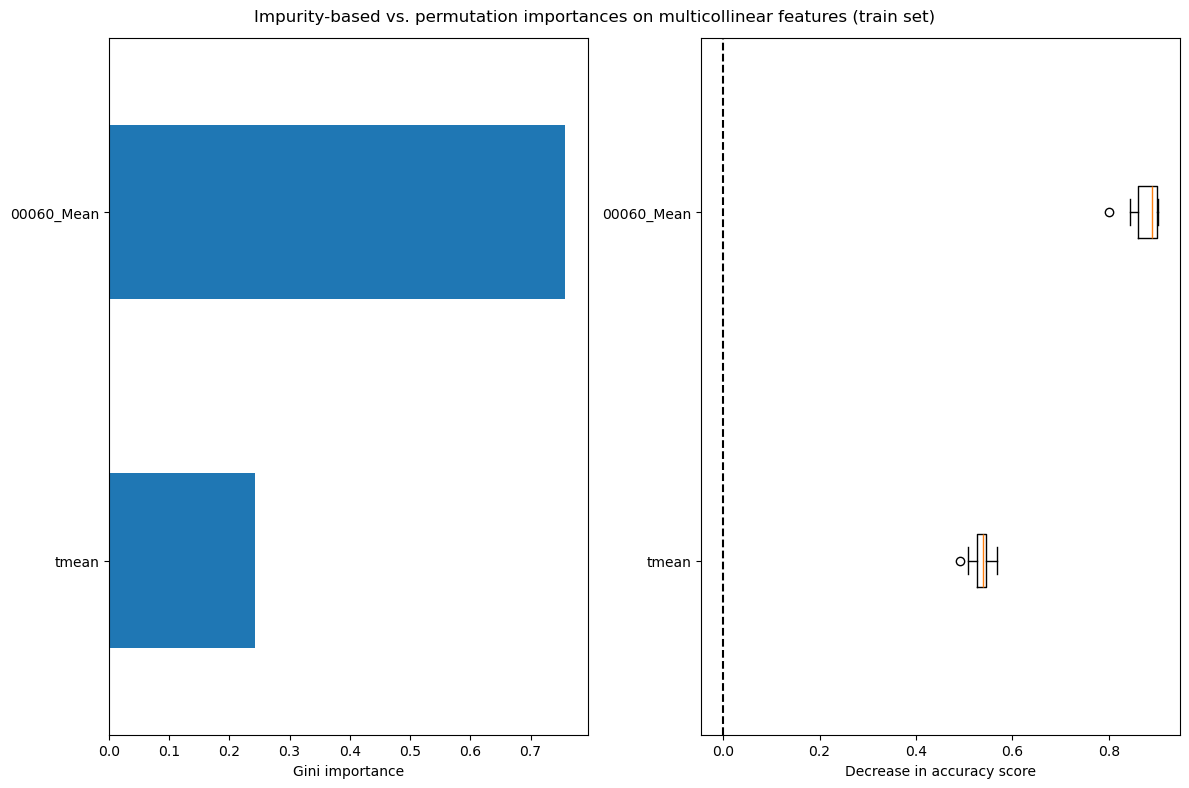

correlation_coefficient: 0.8271555284835433
MSE: 0.896049109690335
RMS: 1.1571870431040736


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


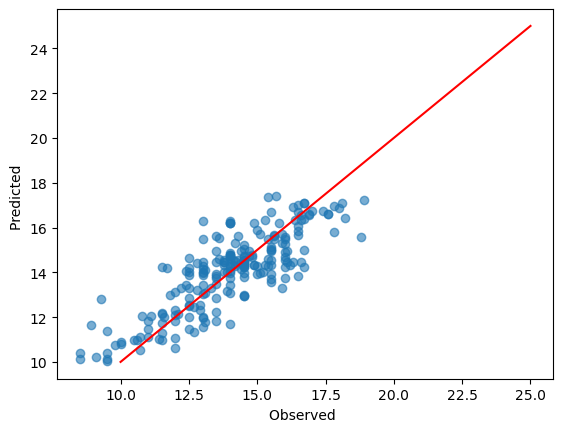

/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_8265/3331447402.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prism_df2['sin_rday'] = np.sin( prism_df2['rad_d'] )
/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_8265/3331447402.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prism_df2['cos_rday'] = np.cos( prism_df2['rad_d'] )
/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_8265/3331447402.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

06038800
dailyStreamtemp_df2:         site_no                  datetime  00010_Maximum 00010_Maximum_cd  \
561    06038800 1995-04-12 00:00:00+00:00            5.5                A   
562    06038800 1995-04-13 00:00:00+00:00            6.5                A   
563    06038800 1995-04-14 00:00:00+00:00            6.0                A   
564    06038800 1995-04-15 00:00:00+00:00            6.5                A   
565    06038800 1995-04-16 00:00:00+00:00            6.5                A   
...         ...                       ...            ...              ...   
11321  06038800 2024-09-26 00:00:00+00:00           16.8                A   
11322  06038800 2024-09-27 00:00:00+00:00           17.1                A   
11323  06038800 2024-09-28 00:00:00+00:00           17.3                A   
11324  06038800 2024-09-29 00:00:00+00:00           16.6                A   
11325  06038800 2024-09-30 00:00:00+00:00           14.4                A   

       00010_Minimum 00010_Minimum_cd  00010_

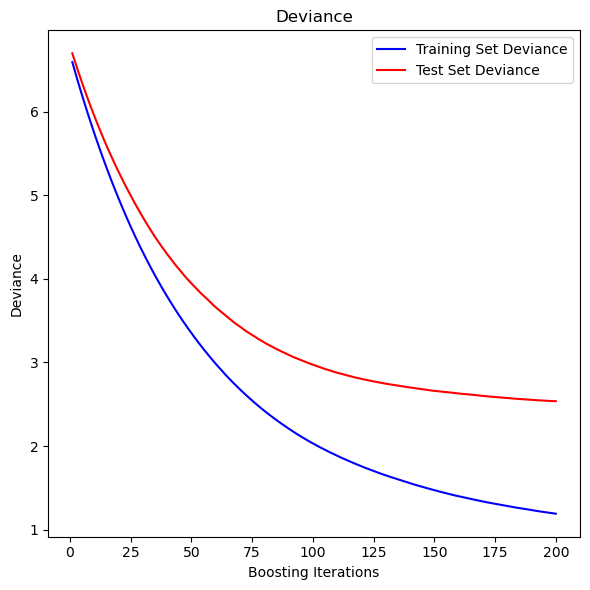

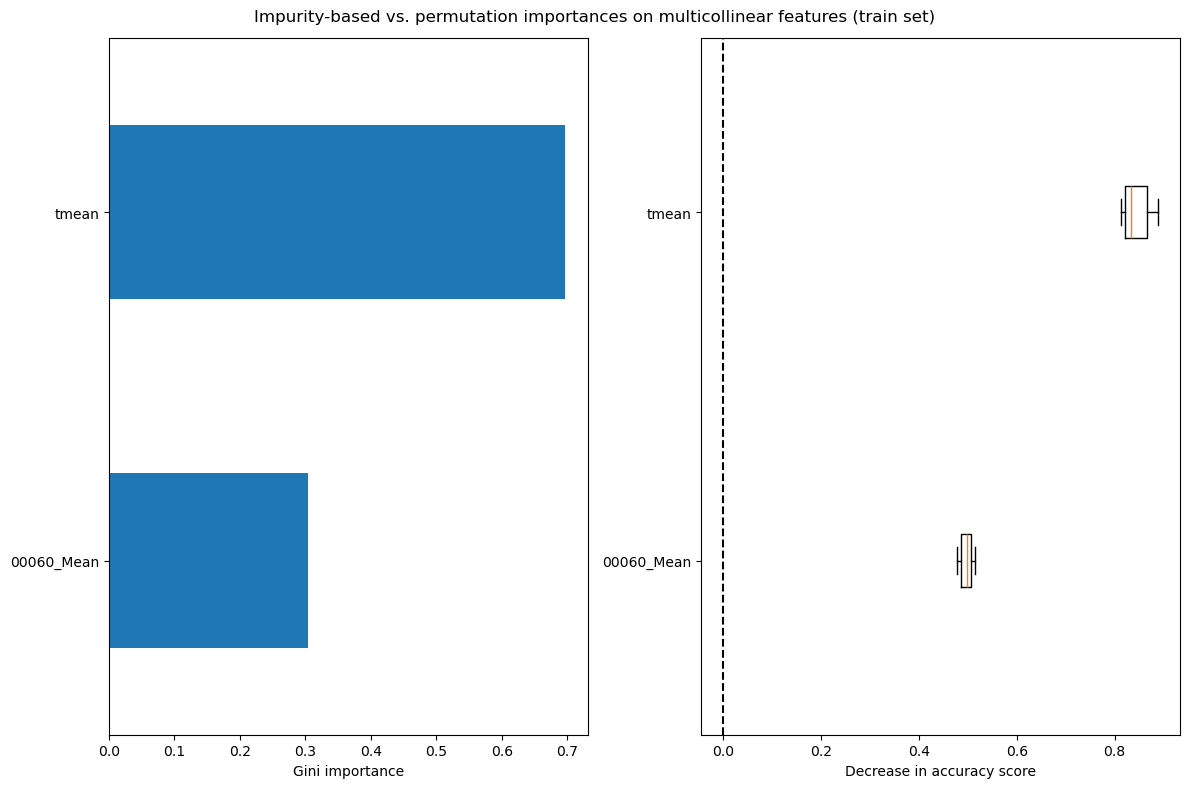

correlation_coefficient: 0.7940343279582528
MSE: 1.2460378141583424
RMS: 1.59290508518706


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


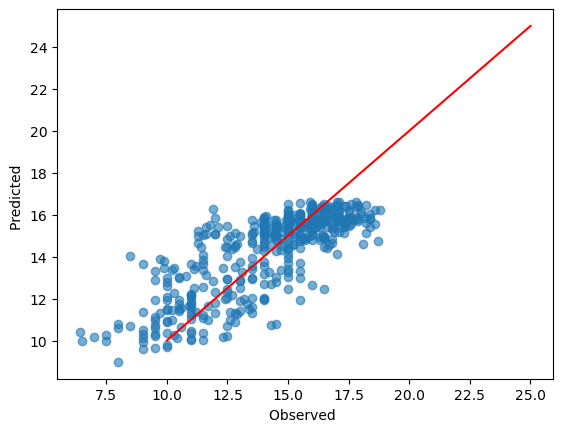

/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_8265/3331447402.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prism_df2['sin_rday'] = np.sin( prism_df2['rad_d'] )
/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_8265/3331447402.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prism_df2['cos_rday'] = np.cos( prism_df2['rad_d'] )
/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_8265/3331447402.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

13340600
dailyStreamtemp_df2:         site_no                  datetime  00010_Maximum 00010_Maximum_cd  \
46390  13340600 1999-10-01 00:00:00+00:00            8.5                A   
46391  13340600 1999-10-02 00:00:00+00:00            8.0                A   
46392  13340600 1999-10-03 00:00:00+00:00            7.5                A   
46393  13340600 1999-10-04 00:00:00+00:00            7.0                A   
46394  13340600 1999-10-05 00:00:00+00:00            7.0                A   
...         ...                       ...            ...              ...   
55517  13340600 2024-09-26 00:00:00+00:00           14.7                A   
55518  13340600 2024-09-27 00:00:00+00:00           14.4                A   
55519  13340600 2024-09-28 00:00:00+00:00           14.2                A   
55520  13340600 2024-09-29 00:00:00+00:00           14.1                A   
55521  13340600 2024-09-30 00:00:00+00:00           12.5                A   

       00010_Minimum 00010_Minimum_cd  00010_

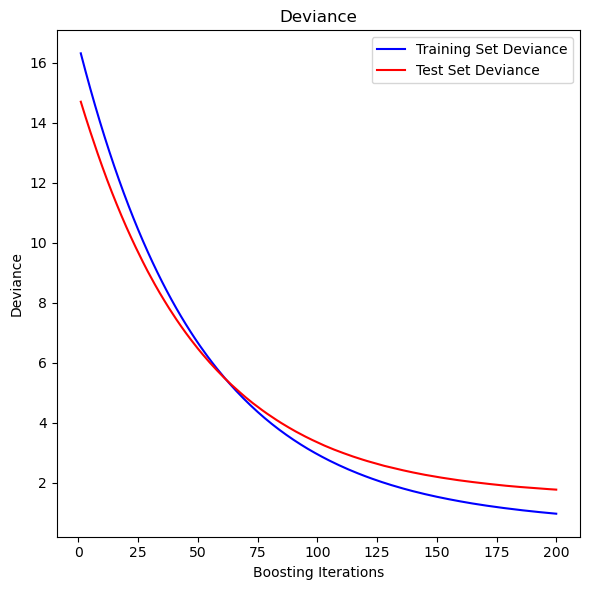

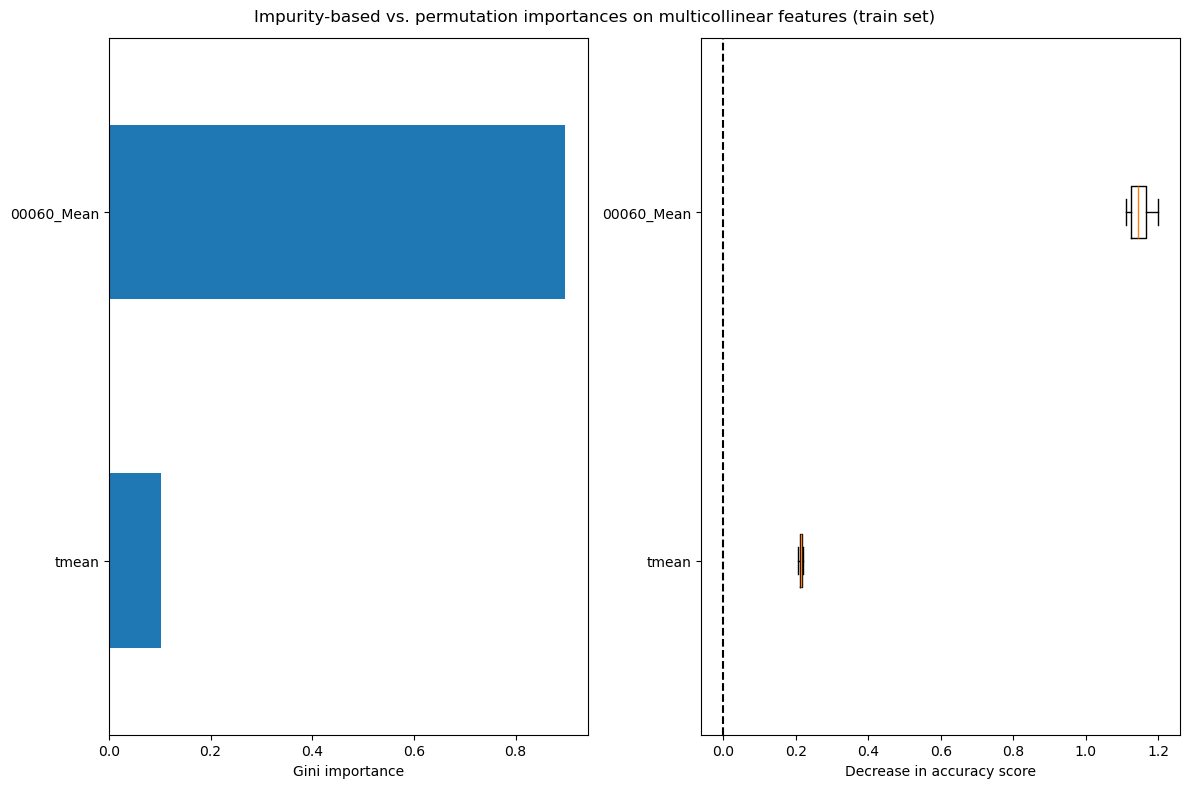

correlation_coefficient: 0.9474731503805551
MSE: 1.0749140197868159
RMS: 1.3280803406567883


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


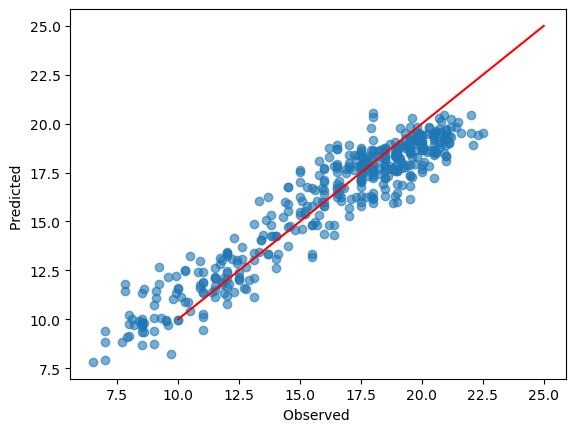

/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_8265/3331447402.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prism_df2['sin_rday'] = np.sin( prism_df2['rad_d'] )
/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_8265/3331447402.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prism_df2['cos_rday'] = np.cos( prism_df2['rad_d'] )
/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_8265/3331447402.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

13092747
dailyStreamtemp_df2:         site_no                  datetime  00010_Maximum 00010_Maximum_cd  \
23933  13092747 1993-04-07 00:00:00+00:00           11.0                A   
23934  13092747 1993-04-08 00:00:00+00:00           12.5                A   
23935  13092747 1993-04-09 00:00:00+00:00           12.0                A   
23936  13092747 1993-04-10 00:00:00+00:00           10.0                A   
23937  13092747 1993-04-11 00:00:00+00:00            9.5                A   
...         ...                       ...            ...              ...   
35428  13092747 2024-09-26 00:00:00+00:00           15.9                P   
35429  13092747 2024-09-27 00:00:00+00:00           15.7                P   
35430  13092747 2024-09-28 00:00:00+00:00           15.9                P   
35431  13092747 2024-09-29 00:00:00+00:00           16.0                P   
35432  13092747 2024-09-30 00:00:00+00:00           15.0                P   

       00010_Minimum 00010_Minimum_cd  00010_

ValueError: Input X contains NaN.
GradientBoostingRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [7]:
params = {
    "n_estimators":  200,
    "max_depth": 8,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

for site in siteNumber: # prism_df["site_no"].unique(): #

    print(site)
    prism_df2 = prism_df[prism_df["site_no"] == site ]
    prism_df2['sin_rday'] = np.sin( prism_df2['rad_d'] )
    prism_df2['cos_rday'] = np.cos( prism_df2['rad_d'] )

    dailyStream_df['Date'] = pd.to_datetime( dailyStream_df['Date'])
    dailyStream_df["site_no"] = dailyStream_df["site_no"].astype(str)
    dailyStream_df2=dailyStream_df[ dailyStream_df['site_no'] == site        ]
    print(     "dailyStreamtemp_df2:",    dailyStream_df2 )
    merged_df = pd.merge( prism_df2,  dailyStream_df2,     left_on='date', right_on='Date',  how='outer')
    merged_df = merged_df[ merged_df['Month'].isin( [6,7,8] )    ]
    print( merged_df.head()         )
    
    print(site)
    input=  merged_df[  idv]
    print(input)
    X_train, X_test, y_train, y_test = train_test_split( input,  merged_df['00010_Mean'], test_size=0.2, random_state=42)
    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(X_train, y_train)

    mse = mean_squared_error(y_test, reg.predict(X_test))

    test_score = np.zeros((params["n_estimators"],), dtype=np.float64)

    for i, y_pred in enumerate(reg.staged_predict(X_test)):
        test_score[i] = mean_squared_error(y_test, y_pred)

    fig = plt.figure(figsize=(6, 6))
    plt.subplot(1, 1, 1)
    plt.title("Deviance")
    plt.plot(
        np.arange(params["n_estimators"]) + 1,
        reg.train_score_,
        "b-",
        label="Training Set Deviance",
    )
    plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
    )
    plt.legend(loc="upper right")
    plt.xlabel("Boosting Iterations")
    plt.ylabel("Deviance")
    fig.tight_layout()
    plt.show()

    mdi_importances = pd.Series(reg.feature_importances_, index=X_train.columns)
    tree_importance_sorted_idx = np.argsort(reg.feature_importances_)
    tree_indices = np.arange(0, len(reg.feature_importances_)) + 0.5

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    mdi_importances.sort_values().plot.barh(ax=ax1)
    ax1.set_xlabel("Gini importance")
    plot_permutation_importance(reg, X_train, y_train, ax2)
    ax2.set_xlabel("Decrease in accuracy score")
    fig.suptitle(
        "Impurity-based vs. permutation importances on multicollinear features (train set)"
    )
    _ = fig.tight_layout()

    plt.show()


    
    train_fit=reg.predict(X_train)
    yfit = reg.predict(X_test)

    correlation_coefficient = np.corrcoef(y_test , yfit)[0, 1]
    rms = mean_squared_error(y_test, yfit, squared=False)
# Print the correlation coefficient
    print("correlation_coefficient:",correlation_coefficient)
    print("MSE:", mean_absolute_error( y_test , yfit ) )
    print("RMS:",rms)



# Plot the estimated linear regression line with matplotlib:
    plt.scatter( y_test , yfit , alpha=0.6)
# Set the x-axis label
    plt.xlabel("Observed ")
    plt.ylabel("Predicted ")

    x = np.linspace(10, 25, 25)
    y = x
    plt.plot(x, y, color='red')

    plt.show()
